# HW#1
## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
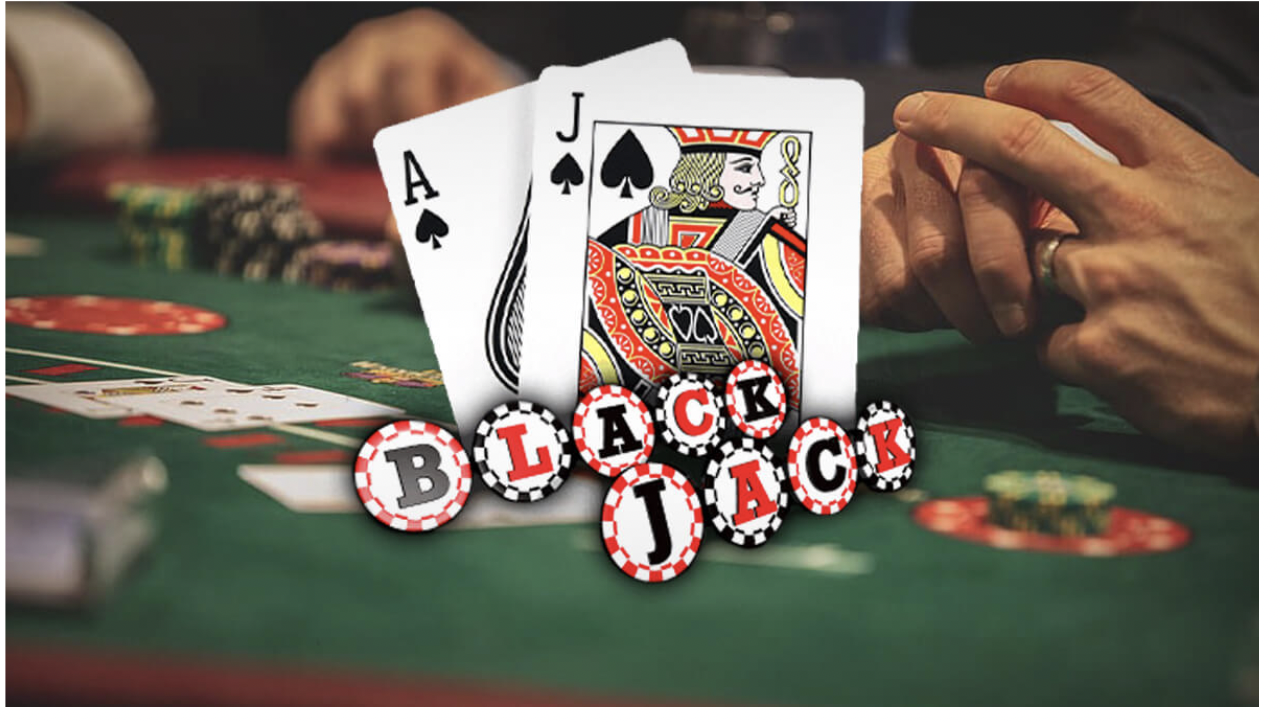
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае  говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
    hit  — взять ещё одну карту;
    stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [50]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import gym
from gym import spaces
from gym.envs.toy_text.blackjack import *

import pandas as pd
import numpy as np
import os

from collections import defaultdict


In [51]:
plt.style.use('bmh')
env = gym.make('Blackjack-v1', natural=True)

In [54]:
def first_policy(state):
    if state[0] >= 19:
        return STAND
    return HIT 


def run_simple_policy(env, pi, n_episodes):
    rewards = []
    wins = 0
    print("Результаты простой стратегии:")
        
    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        
        while pi(state) == HIT: 
            next_state, reward, done, info, _ = env.step(pi(state))
            reward = env.step(STAND)[1]

            
            state = next_state
            if done:
                break
        if reward == 1:
            wins += 1
        rewards.append(reward)
        # monitor progress
        if i_episode % (n_episodes * 0.1) == 0:
            print(f"Эпизод {i_episode}/{n_episodes}.")
            print(f"Средний выигрыш {np.mean(rewards)}")
            print(f"Процент выйгрышей {(wins / i_episode):.0%}")            
    return rewards, wins

In [55]:
# Определим первую стратегию, где 0 - это stand и 1 - hit
STAND = 0
HIT = 1
N_EPISODES = 100000

rewards, wins = run_simple_policy(env, first_policy, N_EPISODES)

Результаты простой стратегии:
Эпизод 10000/100000.
Средний выигрыш -0.2159
Процент выйгрышей 28%
Эпизод 20000/100000.
Средний выигрыш -0.23245
Процент выйгрышей 27%
Эпизод 30000/100000.
Средний выигрыш -0.22886666666666666
Процент выйгрышей 27%
Эпизод 40000/100000.
Средний выигрыш -0.224275
Процент выйгрышей 27%
Эпизод 50000/100000.
Средний выигрыш -0.222
Процент выйгрышей 27%
Эпизод 60000/100000.
Средний выигрыш -0.22491666666666665
Процент выйгрышей 27%
Эпизод 70000/100000.
Средний выигрыш -0.2264857142857143
Процент выйгрышей 27%
Эпизод 80000/100000.
Средний выигрыш -0.2271
Процент выйгрышей 27%
Эпизод 90000/100000.
Средний выигрыш -0.2276
Процент выйгрышей 27%
Эпизод 100000/100000.
Средний выигрыш -0.22773
Процент выйгрышей 27%


In [56]:
pd.Series(rewards).value_counts(normalize=True)

-1.0    0.49880
 1.0    0.27107
 0.0    0.23013
dtype: float64

### По результатам простой стратегии процент выйгрыша 27%, проигрышей - 50 %, ничья - 23%.  Средний выйгрыш по итогам обучения -0.23.


Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.


# MC-control

In [57]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s


def generate_episode_from_Q(env, Q, epsilon, nA, rewards, wins):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()[0]
    while True:
        if state in Q.keys():
            probs = get_probs(Q[state], epsilon, nA)
            action = np.random.choice(np.arange(nA), p=probs) 
        else:
            action = env.action_space.sample()
            
        next_state, reward, done, info, _ = env.step(action)
#         rewards.append(reward)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    if reward >= 1:
        wins += 1
    rewards.append(reward)
    return episode, rewards, wins


def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [58]:
def mc_control(env, n_episodes, alpha, gamma, eps_start=.005, eps_decay=.99999, eps_min=0.05, verbose=True):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    rewards = []
    wins = 0
    if verbose == True:
        print("Результаты MC-control стратегии:")
    
    for i_episode in range(1, n_episodes+1):
    

        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode, rewards, wins = generate_episode_from_Q(env, Q, epsilon, nA, rewards, wins)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        
        # monitor progress
        if i_episode % (n_episodes * 0.1) == 0 and verbose == True:
            print(f"Эпизод {i_episode}/{n_episodes}.")
            print(f"Средний выигрыш {np.mean(rewards)}")
            print(f"Процент выйгрышей {(wins / i_episode):.0%}")   
#     determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q , rewards, wins

In [59]:
alpha = 0.015
gamma = 0.1
n_episodes = 100000
policy, Q, rewards_mc, wins_mc = mc_control(env, n_episodes, alpha, gamma, verbose = True)

Результаты MC-control стратегии:
Эпизод 10000/100000.
Средний выигрыш -0.1031
Процент выйгрышей 41%
Эпизод 20000/100000.
Средний выигрыш -0.0928
Процент выйгрышей 41%
Эпизод 30000/100000.
Средний выигрыш -0.08803333333333334
Процент выйгрышей 41%
Эпизод 40000/100000.
Средний выигрыш -0.088
Процент выйгрышей 41%
Эпизод 50000/100000.
Средний выигрыш -0.08384
Процент выйгрышей 42%
Эпизод 60000/100000.
Средний выигрыш -0.08005
Процент выйгрышей 42%
Эпизод 70000/100000.
Средний выигрыш -0.07738571428571428
Процент выйгрышей 42%
Эпизод 80000/100000.
Средний выигрыш -0.0752
Процент выйгрышей 42%
Эпизод 90000/100000.
Средний выигрыш -0.0745
Процент выйгрышей 42%
Эпизод 100000/100000.
Средний выигрыш -0.07341
Процент выйгрышей 42%


In [64]:
pd.Series(rewards_mc).value_counts(normalize=True)

-1.0    0.49540
 1.0    0.42199
 0.0    0.08261
dtype: float64

### По результатам стратегии MC-control с параметрами alpha = 0.015, gamma = 0.1, n_episodes = 100000 процент выйгрыша 42%, проигрышей - 50%, ничья - 8%. Средний выйгрыш по итогам обучения -0.073.


Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


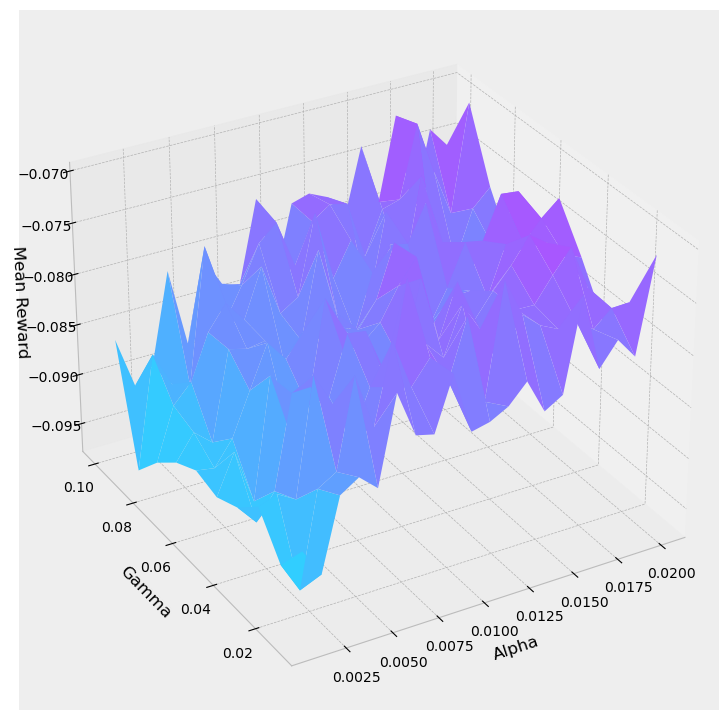

In [261]:
def get_Z(alpha, gamma):
    _, _, rewards_mc, _ = mc_control(env, n_episodes, alpha, gamma, verbose = False)
    return np.mean(rewards_mc)

gammas = np.linspace(0.01, 0.1, 10)
alphas = np.linspace(0.001, 0.02, 20)
X, Y = np.meshgrid(alphas, gammas)

Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(211, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.cool, vmin=-0.1, vmax=-0.06)
ax.set_xlabel('Alpha')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Reward')
ax.view_init(ax.elev, -120)

plt.show()

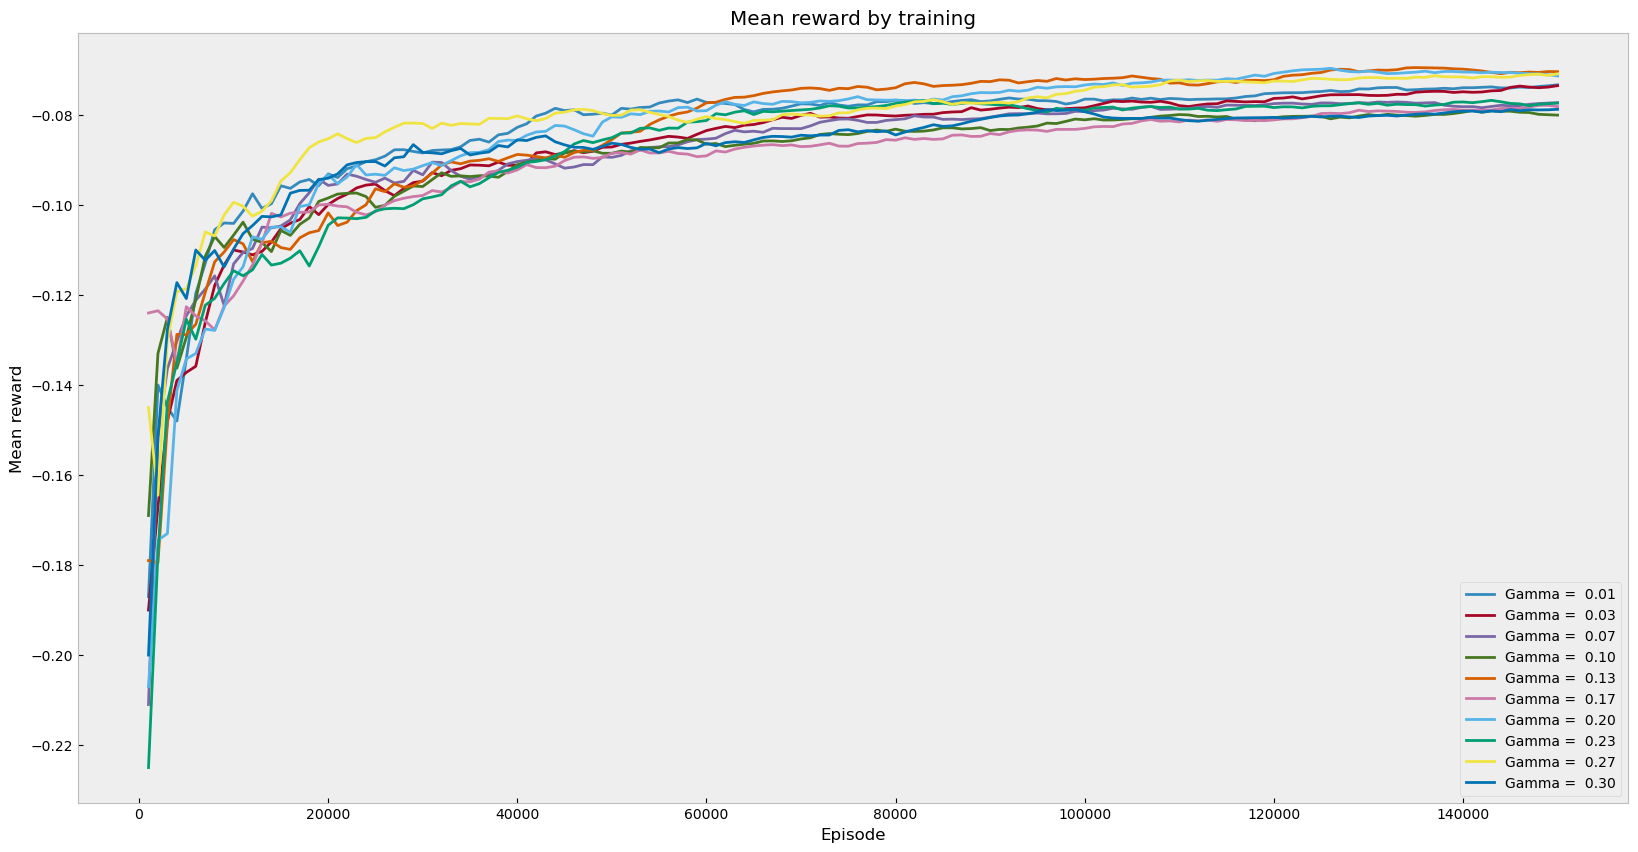

In [336]:
def get_rewards(gamma):
    _, _, rewards_mc, _ = mc_control(env, n_episodes, alpha, gamma, verbose = False)
    result = [np.mean(rewards_mc[:i]) for i in range(0,n_episodes+1,1000)]
    return result

alpha = 0.02
n_episodes = 150000
gammas = np.linspace(0.0, 0.3, 10)

plt.figure(figsize=(20, 10))

for gamma in gammas:
    if gamma == 0:
        gamma = 0.01
    rewards = get_rewards(gamma)
    plt.plot(range(0, n_episodes+1, 1000), rewards, label="Gamma =  %.2f" % (gamma))
plt.title('Mean reward by training')
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.legend(loc="lower right")
plt.grid()

# Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [7]:
from blackjackdouble import BlackjackDoubleEnv
env_double = BlackjackDoubleEnv(natural=True)

In [9]:
env_double = BlackjackDoubleEnv(natural=True)

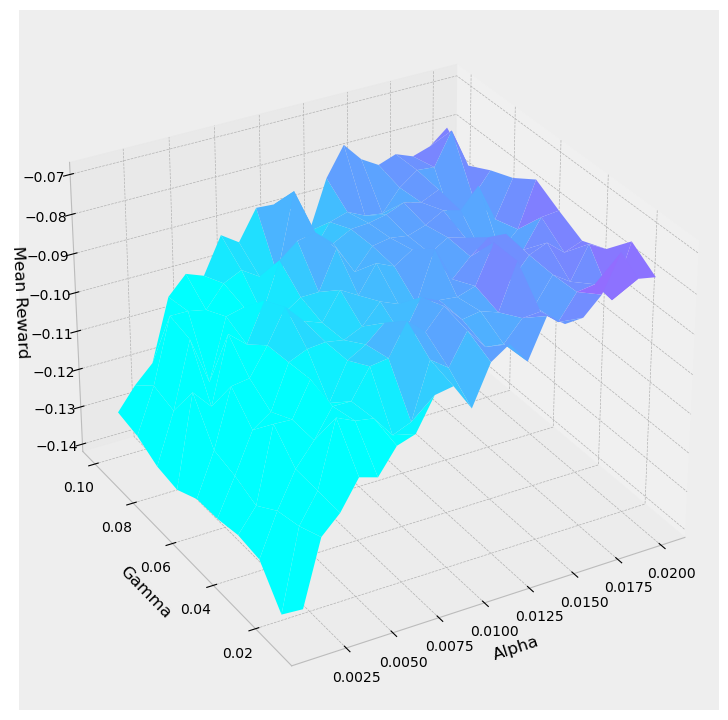

In [14]:
def get_Z(env, alpha, gamma):
    _, _, rewards_mc, _ = mc_control(env, n_episodes, alpha, gamma, verbose = False)
    return np.mean(rewards_mc)

gammas = np.linspace(0.01, 0.1, 10)
alphas = np.linspace(0.001, 0.02, 20)
X, Y = np.meshgrid(alphas, gammas)

Z = np.array([get_Z(env_double, x, y) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(211, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.cool, vmin=-0.1, vmax=-0.06)
ax.set_xlabel('Alpha')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Reward')
ax.view_init(ax.elev, -120)

plt.show()

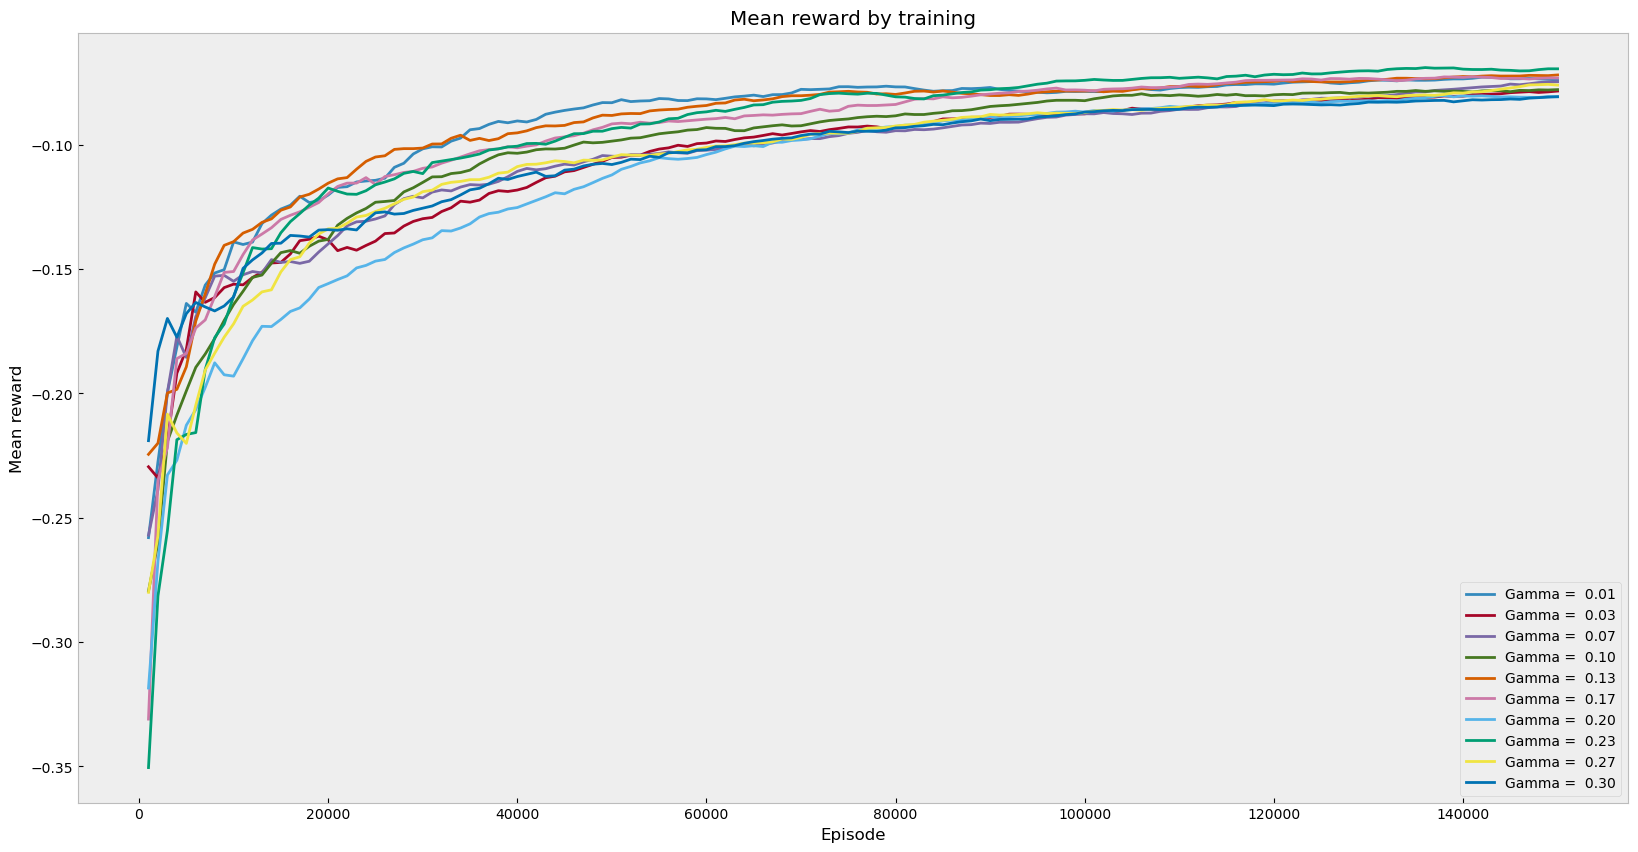

In [43]:
def get_rewards(gamma):
    _, _, rewards_mc, _ = mc_control(env_double, n_episodes, alpha, gamma, verbose = False)
    result = [np.mean(rewards_mc[:i]) for i in range(0,n_episodes+1,1000)]
    return result

alpha = 0.02
n_episodes = 150000
gammas = np.linspace(0.0, 0.3, 10)

plt.figure(figsize=(20, 10))

for gamma in gammas:
    if gamma == 0:
        gamma = 0.01
    rewards = get_rewards(gamma)
    plt.plot(range(0, n_episodes+1, 1000), rewards, label="Gamma =  %.2f" % (gamma))
plt.title('Mean reward by training')
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.legend(loc="lower right")
plt.grid()

In [138]:
alpha = 0.02
gamma = 0.23
n_episodes = 1000000
policy, Q, rewards_mc, wins_mc = mc_control(env_double, n_episodes, alpha, gamma, verbose = True)

Результаты MC-control стратегии:
Эпизод 100000/1000000.
Средний выигрыш -0.0794
Процент выйгрышей 41%
Эпизод 200000/1000000.
Средний выигрыш -0.06741
Процент выйгрышей 42%
Эпизод 300000/1000000.
Средний выигрыш -0.06417
Процент выйгрышей 42%
Эпизод 400000/1000000.
Средний выигрыш -0.062855
Процент выйгрышей 42%
Эпизод 500000/1000000.
Средний выигрыш -0.060229
Процент выйгрышей 42%
Эпизод 600000/1000000.
Средний выигрыш -0.059585
Процент выйгрышей 42%
Эпизод 700000/1000000.
Средний выигрыш -0.05907071428571429
Процент выйгрышей 42%
Эпизод 800000/1000000.
Средний выигрыш -0.0580675
Процент выйгрышей 42%
Эпизод 900000/1000000.
Средний выигрыш -0.05771833333333334
Процент выйгрышей 42%
Эпизод 1000000/1000000.
Средний выигрыш -0.056544
Процент выйгрышей 42%


In [139]:
pd.Series(rewards_mc).value_counts(normalize=True)

-1.0    0.458272
 1.0    0.348180
 0.0    0.088428
 1.5    0.040488
-2.0    0.034112
 2.0    0.030520
dtype: float64

### По результатам стратегии MC-control c double ставками с параметрами alpha = 0.02, gamma = 0.23, n_episodes = 100000 процент выйгрыша 42%, проигрышей - 49%, ничья - 9%. Средний выйгрыш по итогам обучения составляет -0.057. 

# Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [41]:
from blackjackcount import BlackjackCountDoubleEnv
env_count = BlackjackCountDoubleEnv(natural=True)

/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


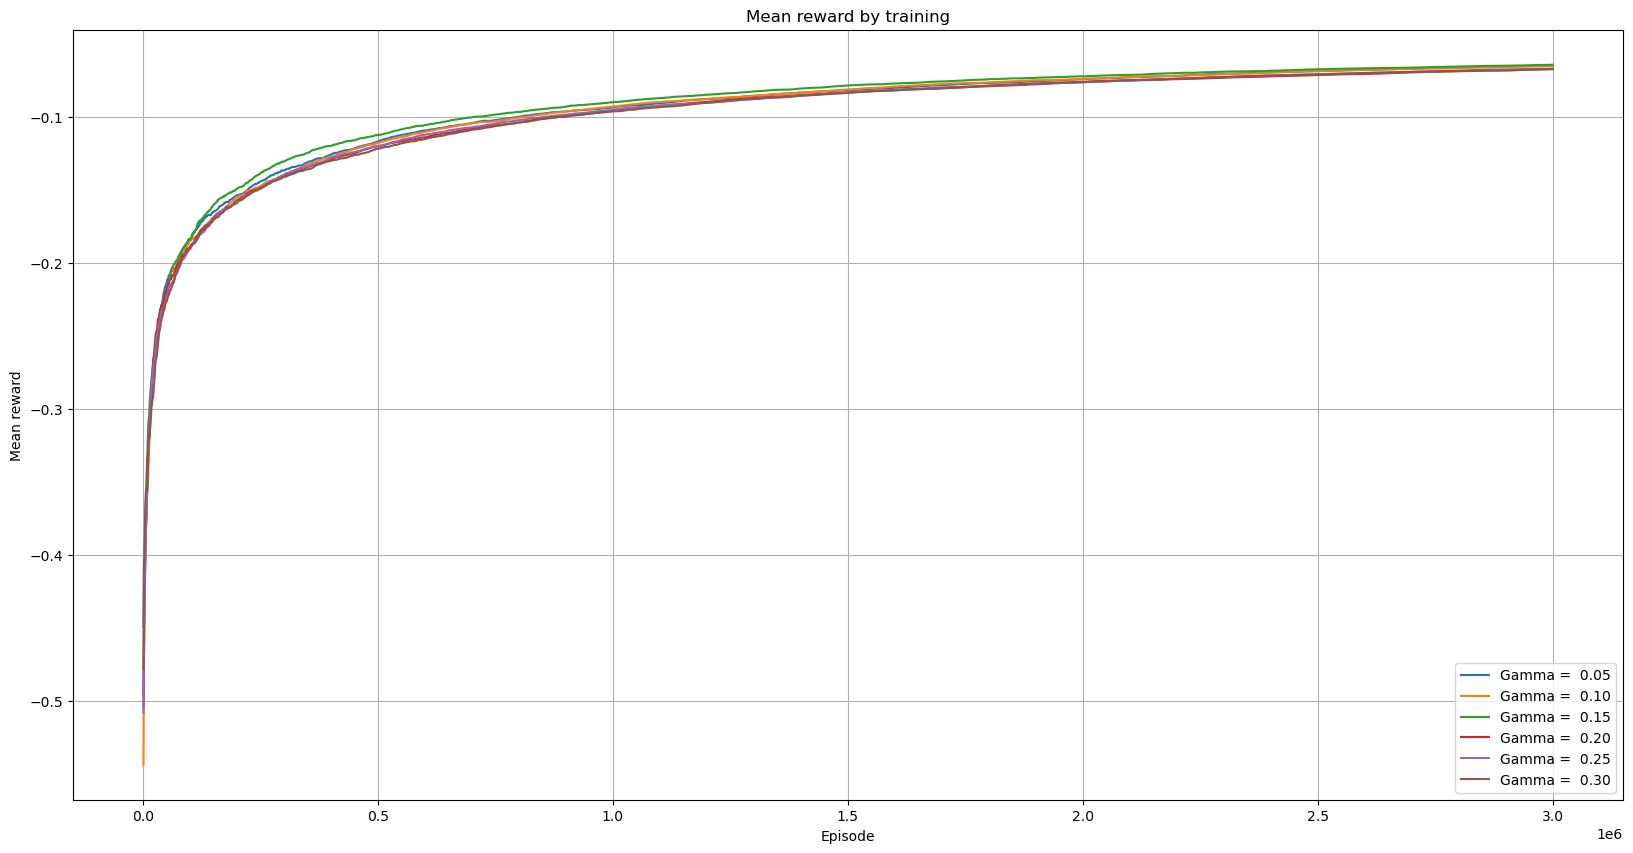

In [6]:
def get_rewards(gamma):
    _, _, rewards_mc, _ = mc_control(env_count, n_episodes, alpha, gamma, verbose = False)
    result = [np.mean(rewards_mc[:i]) for i in range(0,n_episodes+1,1000)]
    return result

alpha = 0.02
n_episodes = 3000000
gammas = np.linspace(0.05, 0.3, 6)

plt.figure(figsize=(20, 10))

for gamma in gammas:
    if gamma == 0:
        gamma = 0.01
    rewards = get_rewards(gamma)
    plt.plot(range(0, n_episodes+1, 1000), rewards, label="Gamma =  %.2f" % (gamma))
plt.title('Mean reward by training')
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.legend(loc="lower right")
plt.grid()

In [17]:
alpha = 0.02
gamma = 0.15
n_episodes = 5000000
policy, Q, rewards_mc, wins_mc = mc_control(env_count, n_episodes, alpha, gamma, verbose = True)

Результаты MC-control стратегии:
Эпизод 500000/5000000.
Средний выигрыш -0.122414
Процент выйгрышей 41%
Эпизод 1000000/5000000.
Средний выигрыш -0.0986935
Процент выйгрышей 41%
Эпизод 1500000/5000000.
Средний выигрыш -0.08531366666666666
Процент выйгрышей 42%
Эпизод 2000000/5000000.
Средний выигрыш -0.0770645
Процент выйгрышей 42%
Эпизод 2500000/5000000.
Средний выигрыш -0.0718764
Процент выйгрышей 42%
Эпизод 3000000/5000000.
Средний выигрыш -0.06764466666666667
Процент выйгрышей 42%
Эпизод 3500000/5000000.
Средний выигрыш -0.06449914285714285
Процент выйгрышей 42%
Эпизод 4000000/5000000.
Средний выигрыш -0.061794125
Процент выйгрышей 42%
Эпизод 4500000/5000000.
Средний выигрыш -0.05958533333333333
Процент выйгрышей 42%
Эпизод 5000000/5000000.
Средний выигрыш -0.0574455
Процент выйгрышей 42%


In [19]:
pd.Series(rewards_mc).value_counts(normalize=True)

-1.0    0.444031
 1.0    0.336498
 0.0    0.084110
-2.0    0.050251
 2.0    0.045848
 1.5    0.039262
dtype: float64

### По результатам стратегии MC-control c double ставками и с подсчетом карт с параметрами alpha = 0.02, gamma = 0.15, n_episodes = 5000000 процент выйгрыша 42.2%, проигрышей - 49.4%, ничья - 8,4%. Средний выгрыш по итогам обучения -0.057. 
По графикам видно, что модели не дообучились, поэтому при дальнейшем обучении можно получить более выйгрышные стратегии и лучшие результаты.